![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

## NLP2 Lecture 1 Support Notebook

### Table of Contents
<p>
<div class="lev1">
    <a href="#Mean-Reciprocal-Rank-(MRR)"><span class="toc-item-num">2&nbsp;&nbsp;</span>
        Mean Reciprocal Rank (MRR)
    </a>
</div>
</div>
<div class="lev1">
    <a href="#Mean-Average-Precision-(MAP)"><span class="toc-item-num">3&nbsp;&nbsp;</span>
        Mean Average Precision (MAP)
    </a>
</div>
<div class="lev1">
    <a href="#Text-Generation-with-RNN"><span class="toc-item-num">4&nbsp;&nbsp;</span>
        Text Generation with RNN
    </a>
</div>
<div class="lev1">
    <a href="#Building-an-Attention-Model"><span class="toc-item-num">5&nbsp;&nbsp;</span>
        Building an Attention Model
    </a>

# Mean-Reciprocal-Rank-(MRR)
Mean reciprocal rank (MRR) gives you a general measure of quality in these situations, but MRR only cares about the single highest-ranked relevant item. If your system returns a relevant item in the third-highest spot, that's what MRR cares about. It doesn't care if the other relevant items (assuming there are any) are ranked number 4 or number 20.<br/>
Therefore, MRR is appropriate to judge a system where either (a) there's only one relevant result, or (b) in your use-case you only really care about the highest-ranked one. This might be true in some web-search scenarios, for example, where the user just wants to find one thing to click on, they don't need any more. (Though is that typically true, or would you be more happy with a web search that returned ten pretty good answers, and you could make your own judgment about which of those to click on...?) <br/>

ref. https://stats.stackexchange.com/questions/127041/mean-average-precision-vs-mean-reciprocal-rank

In [1]:
"""Information Retrieval metrics
Useful Resources:
http://www.cs.utexas.edu/~mooney/ir-course/slides/Evaluation.ppt
http://www.nii.ac.jp/TechReports/05-014E.pdf
http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
http://hal.archives-ouvertes.fr/docs/00/72/67/60/PDF/07-busa-fekete.pdf
Learning to Rank for Information Retrieval (Tie-Yan Liu)
"""
import numpy as np


def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])

In [2]:
rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
mean_reciprocal_rank(rs)

0.611111111111111

In [3]:
rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
mean_reciprocal_rank(rs)

0.5

In [4]:
rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
mean_reciprocal_rank(rs)

0.75

## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#NLP2-Lecture-1-Support-Notebook">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        Go to TOP
    </a>
</div>

# Mean-Average-Precision-(MAP)
It considers whether all of the relevant items tend to get ranked highly. So in the top-20 example, it doesn't only care if there's a relevant answer up at number 3, it also cares whether all the "yes" items in that list are bunched up towards the top.

There's no real need to use MAP if you only ever have 1 relevant answer in your data, MRR would be fine. But if you submit a query such as "female heads of state" and the top three results are "Margaret Thatcher", "Vigdís Finnbogadóttir", and "Pratibha Patil", those all are distinct but correct answers, and we might want to judge this as a good result, better than a system which only floated one of those answers to the top <br/>

Below we have the functions to implement that: precision_at_k, average_precision and mean_average_precision.

ref. https://stats.stackexchange.com/questions/127041/mean-average-precision-vs-mean-reciprocal-rank

In [5]:
def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

In [6]:
def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

In [7]:
def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])

In [8]:
rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
mean_average_precision(rs)

0.7833333333333333

In [9]:
rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
mean_average_precision(rs)

0.39166666666666666

## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#NLP2-Lecture-1-Support-Notebook">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        Go to TOP
    </a>
</div>

# Text Generation with RNN
In this section we implement a language model introduced in :numref:`chap_rnn` from scratch. It is based on a character-level recurrent neural network trained on H. G. Wells' *The Time Machine*. As before, we start by reading the dataset first, which is introduced in :numref:`sec_language_model`.

In [10]:
# !pip install -q -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install -q git+https://github.com/d2l-ai/d2l-en # installing d2

In [11]:
!pip install -q torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

In [12]:
%matplotlib inline
import sys
import math

from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [13]:
d2l.try_all_gpus()

[device(type='cuda', index=0)]

## One-hot Encoding

Remember that each token is presented as a numerical index in `train_iter`.
Feeding these indices directly to the neural network might make it hard to
learn. We often present each token as a more expressive feature vector. The
easiest representation is called *one-hot encoding*.

In a nutshell, we map each index to a different unit vector: assume that the number of different tokens in the vocabulary is $N$ (the `len(vocab)`) and the token indices range from 0 to $N-1$. If the index of a token is the integer $i$, then we create a vector $\mathbf{e}_i$ of all 0s with a length of $N$ and set the element at position $i$ to 1. This vector is the one-hot vector of the original token. The one-hot vectors with indices 0 and 2 are shown below.

In [14]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

The shape of the minibatch we sample each time is (batch size, timestep). The `one_hot` function transforms such a minibatch into a 3-D tensor with the last dimension equals to the vocabulary size. We often transpose the input so that we will obtain a (timestep, batch size, vocabulary size) output that fits into a sequence model easier.

In [15]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## Initializing the Model Parameters

Next, we initialize the model parameters for a RNN model. The number of hidden units `num_hiddens` is a tunable parameter.

In [16]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## RNN Model

First, we need an `init_rnn_state` function to return the hidden state at initialization. It returns an `ndarray` filled with 0 and with a shape of (batch size, number of hidden units). Using tuples makes it easier to handle situations where the hidden state contains multiple variables (e.g., when combining multiple layers in an RNN where each layer requires initializing).

In [17]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

The following `rnn` function defines how to compute the hidden state and output
in a timestep. The activation function here uses the $\tanh$ function. As
described in :numref:`sec_mlp`, the
mean value of the $\tanh$ function is 0, when the elements are evenly
distributed over the real numbers.

In [18]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

Now we have all functions defined, next we create a class to wrap these functions and store parameters.

In [19]:
# Saved in the d2l package for later use

class RNNModelScratch: #@save
    """A RNN Model implemented from scratch."""
    
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Let's do a sanity check whether inputs and outputs have the correct dimensions, e.g., to ensure that the dimensionality of the hidden state has not changed.

In [20]:
%%time
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

CPU times: user 1.19 s, sys: 464 ms, total: 1.65 s
Wall time: 2.43 s


(torch.Size([10, 28]), 1, torch.Size([2, 512]))

We can see that the output shape is (number steps $\times$ batch size, vocabulary size), while the hidden state shape remains the same, i.e., (batch size, number of hidden units).

## Prediction

We first explain the predicting function so we can regularly check the prediction during training. This function predicts the next `num_predicts` characters based on the `prefix` (a string containing several characters). For the beginning of the sequence, we only update the hidden state. After that we begin generating new characters and emitting them.

In [21]:
# Saved in the d2l package for later use
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

We test the `predict_rnn` function first. Given that we did not train the network, it will generate nonsensical predictions. We initialize it with the sequence `traveller ` and have it generate 10 additional characters.

In [22]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller rcamxpxpxp'

## Gradient Clipping

For a sequence of length $T$, we compute the gradients over these $T$ timesteps in an iteration, which results in a chain of matrix-products with length  $\mathcal{O}(T)$ during backpropagating. As mentioned in :numref:`sec_numerical_stability`, it might result in numerical instability, e.g., the gradients may either explode or vanish, when $T$ is large. Therefore, RNN models often need extra help to stabilize the training.

Recall that when solving an optimization problem, we take update steps for the weights $\mathbf{w}$ in the general direction of the negative gradient $\mathbf{g}_t$ on a minibatch, say $\mathbf{w} - \eta \cdot \mathbf{g}_t$. Let's further assume that the objective is well behaved, i.e., it is Lipschitz continuous with constant $L$, i.e.,

$$|l(\mathbf{w}) - l(\mathbf{w}')| \leq L \|\mathbf{w} - \mathbf{w}'\|.$$

In this case we can safely assume that if we update the weight vector by $\eta \cdot \mathbf{g}_t$, we will not observe a change by more than $L \eta \|\mathbf{g}_t\|$. This is both a curse and a blessing. A curse since it limits the speed of making progress, whereas a blessing since it limits the extent to which things can go wrong if we move in the wrong direction.

Sometimes the gradients can be quite large and the optimization algorithm may fail to converge. We could address this by reducing the learning rate $\eta$ or by some other higher order trick. But what if we only rarely get large gradients? In this case such an approach may appear entirely unwarranted. One alternative is to clip the gradients by projecting them back to a ball of a given radius, say $\theta$ via

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$

By doing so we know that the gradient norm never exceeds $\theta$ and that the
updated gradient is entirely aligned with the original direction $\mathbf{g}$.
It also has the desirable side-effect of limiting the influence any given
minibatch (and within it any given sample) can exert on the weight vectors. This
bestows a certain degree of robustness to the model. Gradient clipping provides
a quick fix to the gradient exploding. While it does not entirely solve the problem, it is one of the many techniques to alleviate it.

Below we define a function to clip the gradients of a model that is either a `RNNModelScratch` instance or a Gluon model. Also note that we compute the gradient norm over all parameters.

In [23]:
# Saved in the d2l package for later use
def grad_clipping(net, theta):  #@save
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Training

Let's first define the function to train the model on one data epoch. It differs from the models training of :numref:`sec_softmax_scratch` in three places:

1. Different sampling methods for sequential data (independent sampling and
   sequential partitioning) will result in differences in the initialization of
   hidden states.
1. We clip the gradients before updating the model parameters. This ensures that the model does not diverge even when gradients blow up at some point during the training process, and it effectively reduces the step size automatically.
1. We use perplexity to evaluate the model. This ensures that sequences of different length are comparable.


When the consecutive sampling is used, we initialize the hidden state at the beginning of each epoch. Since the $i^\mathrm{th}$ example in the next minibatch is adjacent to the current $i^\mathrm{th}$ example, so the next minibatch can use the current hidden state directly, we only detach the gradient so that we compute the gradients within a minibatch. When using the random sampling, we need to re-initialize the hidden state for each iteration since each example is sampled with a random position. Same as the `train_epoch_ch3` function in :numref:`sec_softmax_scratch`, we use generalized `updater`, which could be either a Gluon trainer or a scratched implementation.

In [24]:
# Saved in the d2l package for later use

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

The training function again supports either we implement the model from scratch or using Gluon.

In [25]:
# Saved in the d2l package for later use

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Now we can train a model. Since we only use $10,000$ tokens in the dataset, the model needs more epochs to converge.

perplexity 1.0, 66058.4 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travellerywe can show black is white by argument said filby
CPU times: user 1min 19s, sys: 522 ms, total: 1min 19s
Wall time: 1min 19s


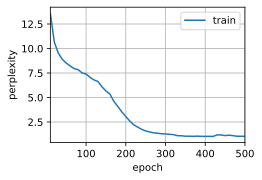

In [26]:
%%time 
# around 1:25 minutes with gpu

num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

Finally let's check the results to use a random sampling iterator.

perplexity 1.4, 61445.1 tokens/sec on cuda:0
time traveller proceeded anyreal body must have extension in fou
travellerit would be remarkably convenient to spethe object
CPU times: user 1min 25s, sys: 279 ms, total: 1min 25s
Wall time: 1min 25s


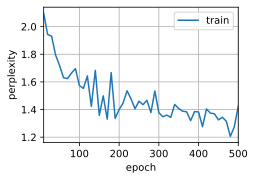

In [28]:
%%time 
# around 1:25 minutes with gpu

train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

While implementing the above RNN model from scratch is instructive, it is not convenient. In the next section we will see how to improve significantly on the current model and how to make it faster and easier to implement.


## Summary

* Sequence models need state initialization for training.
* Between sequential models you need to ensure to detach the gradients, to ensure that the automatic differentiation does not propagate effects beyond the current sample.
* A simple RNN language model consists of an encoder, an RNN model, and a decoder.
* Gradient clipping prevents gradient explosion (but it cannot fix vanishing gradients).
* Perplexity calibrates model performance across different sequence length. It is the exponentiated average of the cross-entropy loss.
* Sequential partitioning typically leads to better models.

## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#NLP2-Lecture-1-Support-Notebook">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        Go to TOP
    </a>
</div>

# Building an Attention Model

In [29]:
!pip install git+https://github.com/d2l-ai/d2l-en
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F

  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-0dfupttk
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [31]:
torch.cuda.device_count()

1

In [33]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [34]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of words in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of words in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of words in sequence A,
        # no. of words in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of words in sequence A,
        # `embed_size`), where sequence B is softly aligned with each word
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of words in sequence B,
        # `embed_size`), where sequence A is softly aligned with each word
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

In [35]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [36]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [37]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [38]:
%%time
# around 1:01 minutes with gpu
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples
CPU times: user 36.6 s, sys: 2.35 s, total: 38.9 s
Wall time: 1min 1s


In [39]:
%%time
# around 0:23 minutes with gpu
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

CPU times: user 20 s, sys: 974 ms, total: 21 s
Wall time: 23 s


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.2871, -0.5999,  0.4688,  ...,  0.3639, -0.8138, -0.2211],
        [ 0.9682,  0.0718,  0.1710,  ...,  0.1024,  1.3345, -0.4854],
        [ 0.1964,  0.0332,  0.1263,  ...,  0.1077,  0.0260,  0.8928]])

### Training the Model

loss 0.494, train acc 0.806, test acc 0.821
6573.8 examples/sec on [device(type='cuda', index=0)]
CPU times: user 4min 44s, sys: 1min 14s, total: 5min 58s
Wall time: 6min 1s


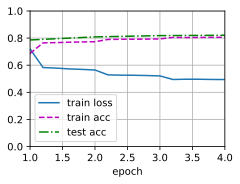

In [40]:
%%time
# around 6:01 minutes with gpu
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
# net.export("lenet", epoch=1) # if saving the model

### Predicting

#### Using the model saved previously

In [41]:
def predict_snli(net, vocab, premise, hypothesis):
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [39]:
predict_snli(net, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])
#predict_snli(deserialized_net, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.']) # to use saved model

'contradiction'

## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#NLP2-Lecture-1-Support-Notebook">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        Go to TOP
    </a>
</div>